## Sentiment Classification of Top 10 Businesses in the Yelp Dataset

***
### 1. Data

- Import Data
- Data Exploratory
- Analysis of a single business

***
### 2. Data Cleaning

- Top 10 business
- Create Word Cloud
- Preprocess the text

***
### 3. Data Transformation

- Preprocess the text
- Tokenizer Data
- Data Padding
- Labeling Sentiments
- Split Data to Train and Test Set

***
### 4. Model Design
- Create Embeding Layer
- Model Embeding Layer
- Model Network
- Train Model

***
### 5. Analytical Analysis of Models

- Evaluate Model
- Graphical Representation
- Model Prediction
- Sample Review Analysis



In [3]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import re
import string

from langdetect import detect
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Conv1D, Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Input

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

### Data

#### import Data


In [4]:
review = pd.read_json("yelp_academic_dataset_review.json", lines=True)

review.head()

,votes,user_id,review_id,stars,date,text,type,business_id
0,"{'funny': 0, 'useful': 5, 'cool': 2}",rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,My wife took me here on my birthday for breakf...,review,9yKzy9PApeiPPOUJEtnvkg
1,"{'funny': 0, 'useful': 0, 'cool': 0}",0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,I have no idea why some people give bad review...,review,ZRJwVLyzEJq1VAihDhYiow
2,"{'funny': 0, 'useful': 1, 'cool': 0}",0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love the gyro plate. Rice is so good and I als...,review,6oRAC4uyJCsJl1X0WZpVSA
3,"{'funny': 0, 'useful': 2, 'cool': 1}",uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,_1QQZuf4zZOyFCvXc0o6Vg
4,"{'funny': 0, 'useful': 0, 'cool': 0}",vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,General Manager Scott Petello is a good egg!!!...,review,6ozycU1RpktNG2-1BroVtw


In [5]:
col = review.columns

col

Index(['votes', 'user_id', 'review_id', 'stars', 'date', 'text', 'type',
       'business_id'],
      dtype='object')

#### Data Exploratory

In [6]:
status_vals = review.business_id.value_counts()

status_vals.head()

hW0Ne_HTHEAgGF1rAdmR-g    844
VVeogjZya58oiTxK7qUjAQ    794
JokKtdXU7zXHcr20Lrk29A    731
ntN85eu27C04nwyPa8IHtw    679
EWMwV5V9BxNs_U6nNVMeqw    645
Name: business_id, dtype: int64

In [7]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [8]:
review_sub_stars = count_values_in_column(review, "business_id")

review_sub_stars.head()

,Total,Percentage
hW0Ne_HTHEAgGF1rAdmR-g,844,0.37
VVeogjZya58oiTxK7qUjAQ,794,0.35
JokKtdXU7zXHcr20Lrk29A,731,0.32
ntN85eu27C04nwyPa8IHtw,679,0.30
EWMwV5V9BxNs_U6nNVMeqw,645,0.28


#### Analysis of a single business

In [9]:
review_sub = review.loc[(review['business_id'] == 'hW0Ne_HTHEAgGF1rAdmR-g')]

review_sub.head()

,votes,user_id,review_id,stars,date,text,type,business_id
7,"{'funny': 0, 'useful': 1, 'cool': 0}",1ieuYcKS7zeAv_U15AB13A,JL7GXJ9u4YMx7Rzs05NfiQ,4,2012-07-12,"Luckily, I didn't have to travel far to make m...",review,hW0Ne_HTHEAgGF1rAdmR-g
90,"{'funny': 9, 'useful': 7, 'cool': 7}",8tbXmjYGsYFZXk6ppuwRWQ,6iEP6dvHIefVMMnjeDRNcQ,1,2010-07-06,The beach paradise of Ixtapa-Zihuatenejo await...,review,hW0Ne_HTHEAgGF1rAdmR-g
146,"{'funny': 3, 'useful': 2, 'cool': 2}",gYIHSsoa260H544x9guLOg,t5Hxl0agkS7p3vDnbl3Yyg,3,2010-09-09,I have been through plenty of airports around ...,review,hW0Ne_HTHEAgGF1rAdmR-g
540,"{'funny': 2, 'useful': 2, 'cool': 2}",2FiNCj5rM3nF0qgaWf86Gg,ZSuen309_TLXd9UKZ3ISEw,2,2009-07-04,A pain to get in and out of. I dread each trip...,review,hW0Ne_HTHEAgGF1rAdmR-g
1125,"{'funny': 0, 'useful': 3, 'cool': 1}",A99dyhEqcd_yXKPfBWeZHA,hUIEsrEvC5L-0B45_8bMtQ,4,2012-05-30,"My home airport, so with work travel, I'm pass...",review,hW0Ne_HTHEAgGF1rAdmR-g


In [10]:
# Analysis of ratings 1- 5

review_sub_stars = count_values_in_column(review_sub, "stars")

review_sub_stars

,Total,Percentage
4,292,34.60
3,280,33.18
2,140,16.59
5,78,9.24
1,54,6.40


In [11]:
review_sub.mean()


stars    3.236967
dtype: float64

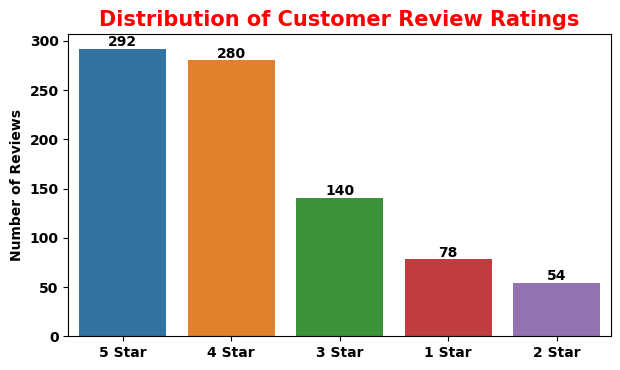

In [12]:
review_sub_stars = count_values_in_column(review_sub,"stars")


plt.figure(figsize=(7,4),dpi=100),
plt.style.use('default')
stars=["5 Star","4 Star","3 Star","1 Star","2 Star"]
ax = sns.barplot(x= stars, y= "Total", data= review_sub_stars)
plt.title("Distribution of Customer Review Ratings", weight= "bold", c= "red", fontsize=15)
plt.xlabel("", weight="bold", c="k")
plt.xticks(rotation=0, weight="bold")
plt.ylabel("Number of Reviews", weight= "bold", c="k")
plt.yticks(weight="bold")


for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',weight="bold", color= 'black')

        
plt.show()

In [13]:
review_sub["year"] = pd.DatetimeIndex(review_sub["date"]).year

In [14]:
review_sub["month"] = pd.DatetimeIndex(review_sub["date"]).month

In [15]:
review_sub.head()

,votes,user_id,review_id,stars,date,text,type,business_id,year,month
7,"{'funny': 0, 'useful': 1, 'cool': 0}",1ieuYcKS7zeAv_U15AB13A,JL7GXJ9u4YMx7Rzs05NfiQ,4,2012-07-12,"Luckily, I didn't have to travel far to make m...",review,hW0Ne_HTHEAgGF1rAdmR-g,2012,7
90,"{'funny': 9, 'useful': 7, 'cool': 7}",8tbXmjYGsYFZXk6ppuwRWQ,6iEP6dvHIefVMMnjeDRNcQ,1,2010-07-06,The beach paradise of Ixtapa-Zihuatenejo await...,review,hW0Ne_HTHEAgGF1rAdmR-g,2010,7
146,"{'funny': 3, 'useful': 2, 'cool': 2}",gYIHSsoa260H544x9guLOg,t5Hxl0agkS7p3vDnbl3Yyg,3,2010-09-09,I have been through plenty of airports around ...,review,hW0Ne_HTHEAgGF1rAdmR-g,2010,9
540,"{'funny': 2, 'useful': 2, 'cool': 2}",2FiNCj5rM3nF0qgaWf86Gg,ZSuen309_TLXd9UKZ3ISEw,2,2009-07-04,A pain to get in and out of. I dread each trip...,review,hW0Ne_HTHEAgGF1rAdmR-g,2009,7
1125,"{'funny': 0, 'useful': 3, 'cool': 1}",A99dyhEqcd_yXKPfBWeZHA,hUIEsrEvC5L-0B45_8bMtQ,4,2012-05-30,"My home airport, so with work travel, I'm pass...",review,hW0Ne_HTHEAgGF1rAdmR-g,2012,5


In [16]:
# Analysis of ratings 1- 5 for each year

review_sub_year = count_values_in_column(review_sub,"year")
review_sub_year

,Total,Percentage
2012,287,34.00
2011,264,31.28
2010,130,15.40
2008,57,6.75
2009,55,6.52
2007,37,4.38
2006,8,0.95
2013,6,0.71


In [17]:
# Analysis of ratings 1- 5 for each month

review_sub_month = count_values_in_column(review_sub,"month")
review_sub_month

,Total,Percentage
12,85,10.07
3,80,9.48
1,79,9.36
8,74,8.77
9,72,8.53
5,72,8.53
6,70,8.29
4,70,8.29
11,65,7.70
7,64,7.58


In [18]:
mean_month =review_sub.groupby("month").stars.mean()
mean_month = pd.DataFrame(mean_month)
mean_month

,stars
month,
1,3.316456
2,2.920000
3,3.025000
4,3.300000
5,3.250000
6,3.314286
7,2.953125
8,3.135135
9,3.333333


In [19]:
mean_year =review_sub.groupby("year").stars.mean()
mean_year = pd.DataFrame(mean_year)
mean_year

,stars
year,
2006,3.500000
2007,3.594595
2008,3.298246
2009,3.054545
2010,3.223077
2011,3.155303
2012,3.285714
2013,3.333333


<AxesSubplot:xlabel='month', ylabel='stars'>

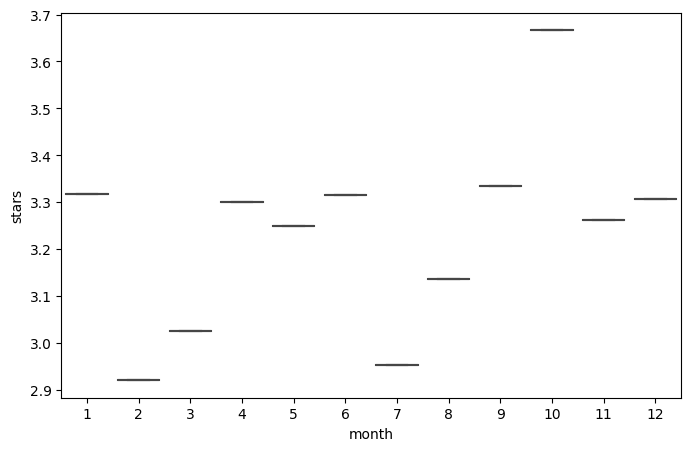

In [20]:
# Mean ratings for each month

plt.figure(figsize=(8,5),dpi=100),
plt.style.use('default')
sns.boxplot(data=mean_month, y="stars",x=mean_month.index)

<AxesSubplot:xlabel='year', ylabel='stars'>

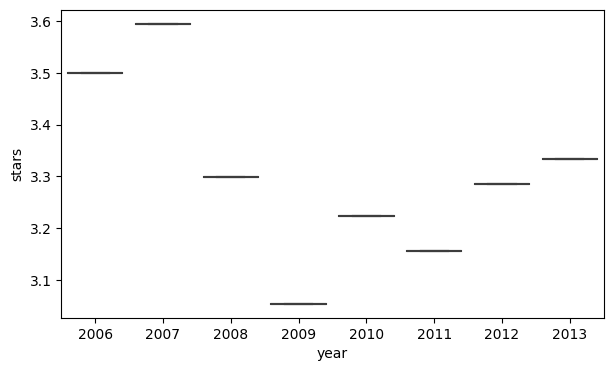

In [21]:
# Mean ratings for each year

plt.figure(figsize=(7,4),dpi=100),
plt.style.use('default')
sns.boxplot(data=mean_year, y="stars",x=mean_year.index)

### Data Cleaning


#### Top 10 business

In [22]:
review_sub_stars = count_values_in_column(review, "business_id")

review_sub_stars.head(10)

,Total,Percentage
hW0Ne_HTHEAgGF1rAdmR-g,844,0.37
VVeogjZya58oiTxK7qUjAQ,794,0.35
JokKtdXU7zXHcr20Lrk29A,731,0.32
ntN85eu27C04nwyPa8IHtw,679,0.30
EWMwV5V9BxNs_U6nNVMeqw,645,0.28
V1nEpIRmEa1768oj_tuxeQ,588,0.26
WNy1uzcmm_UHmTyR--o5IA,575,0.25
SDwYQ6eSu1htn8vHWv128g,568,0.25
-sC66z4SO3tR7nFCjfQwuQ,540,0.23
QnAzW6KMSciUcuJ20oI3Bw,519,0.23


In [23]:
review_sub = review.loc[(review['business_id'] == 'hW0Ne_HTHEAgGF1rAdmR-g') | \
                        (review['business_id'] == 'VVeogjZya58oiTxK7qUjAQ') | \
                        (review['business_id'] == 'JokKtdXU7zXHcr20Lrk29A') | \
                        (review['business_id'] == 'ntN85eu27C04nwyPa8IHtw') | \
                        (review['business_id'] == 'EWMwV5V9BxNs_U6nNVMeqw') | \
                        (review['business_id'] == 'V1nEpIRmEa1768oj_tuxeQ') | \
                        (review['business_id'] == 'WNy1uzcmm_UHmTyR--o5IA') | \
                        (review['business_id'] == 'SDwYQ6eSu1htn8vHWv128g') | \
                        (review['business_id'] == '-sC66z4SO3tR7nFCjfQwuQ') | \
                        (review['business_id'] == 'QnAzW6KMSciUcuJ20oI3Bw')
                       ]

review_sub.head()

,votes,user_id,review_id,stars,date,text,type,business_id
7,"{'funny': 0, 'useful': 1, 'cool': 0}",1ieuYcKS7zeAv_U15AB13A,JL7GXJ9u4YMx7Rzs05NfiQ,4,2012-07-12,"Luckily, I didn't have to travel far to make m...",review,hW0Ne_HTHEAgGF1rAdmR-g
30,"{'funny': 0, 'useful': 2, 'cool': 0}",bCKjygWJZOQHCOzootbvow,dtpJXC5p_sdWDLSobluJ3Q,5,2011-05-09,"Disclaimer: Like many of you, I am a sucker fo...",review,V1nEpIRmEa1768oj_tuxeQ
90,"{'funny': 9, 'useful': 7, 'cool': 7}",8tbXmjYGsYFZXk6ppuwRWQ,6iEP6dvHIefVMMnjeDRNcQ,1,2010-07-06,The beach paradise of Ixtapa-Zihuatenejo await...,review,hW0Ne_HTHEAgGF1rAdmR-g
108,"{'funny': 0, 'useful': 0, 'cool': 0}",a_V8LRfMxGvpGtTwR2olrg,39gCBTrQVeM4GVOt_wEoLg,5,2012-12-16,It's just like pizza bianco without the wait. ...,review,V1nEpIRmEa1768oj_tuxeQ
146,"{'funny': 3, 'useful': 2, 'cool': 2}",gYIHSsoa260H544x9guLOg,t5Hxl0agkS7p3vDnbl3Yyg,3,2010-09-09,I have been through plenty of airports around ...,review,hW0Ne_HTHEAgGF1rAdmR-g


In [24]:
len(review_sub)

6483

In [25]:
review_sub.user_id.nunique()


4860

In [26]:
# Select the texts and the ratings

review = review_sub[["stars","text"]]
review.head(10)

,stars,text
7,4,"Luckily, I didn't have to travel far to make m..."
30,5,"Disclaimer: Like many of you, I am a sucker fo..."
90,1,The beach paradise of Ixtapa-Zihuatenejo await...
108,5,It's just like pizza bianco without the wait. ...
146,3,I have been through plenty of airports around ...
187,4,I love the ambiance at Joe's Farm Grill. It's...
195,4,"Great place for lunch, transport yourself back..."
205,5,"On one of my many visits to see mi amore, he t..."
277,4,We are lucky enough to live basically right ac...
296,4,"I'm going to stop being such a taker, and giv..."


In [27]:
pd.DataFrame(round(review.stars.value_counts(ascending=False, normalize=True),2))

,stars
5,0.42
4,0.35
3,0.13
2,0.06
1,0.03


In [28]:
# Adding Sentiment Columns

review.loc[review['stars'] == 3, 'sentiment'] = 'neutral' 
review.loc[review['stars'] < 3, 'sentiment'] = 'negative' 
review.loc[review['stars'] > 3, 'sentiment'] = 'positive' 
review = review[["stars","sentiment","text"]]

review.head(5)

,stars,sentiment,text
7,4,positive,"Luckily, I didn't have to travel far to make m..."
30,5,positive,"Disclaimer: Like many of you, I am a sucker fo..."
90,1,negative,The beach paradise of Ixtapa-Zihuatenejo await...
108,5,positive,It's just like pizza bianco without the wait. ...
146,3,neutral,I have been through plenty of airports around ...


In [29]:
pd.DataFrame(round(review.sentiment.value_counts(ascending=False, normalize=True),6))

,sentiment
positive,0.774179
neutral,0.134197
negative,0.091624


In [30]:
positive = len(review[review["sentiment"]=="positive"])
negative = len(review[review["sentiment"]=="negative"])
neutral = len(review[review["sentiment"]=="neutral"])

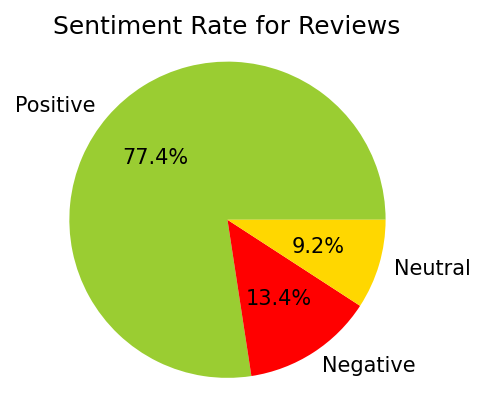

In [31]:
pie_sentiment = review.sentiment.value_counts(normalize=True)
plt.figure(figsize=(3,3),dpi=150),
labels = 'Positive','Negative',"Neutral"
colors = ['yellowgreen', 'red','gold']
plt.pie(pie_sentiment, colors=colors,labels=labels,autopct='%1.1f%%')
plt.style.use('default')
plt.title('Sentiment Rate for Reviews')
plt.axis('equal')
sizes = [positive, neutral, negative]
plt.show()

<AxesSubplot:ylabel='sentiment'>

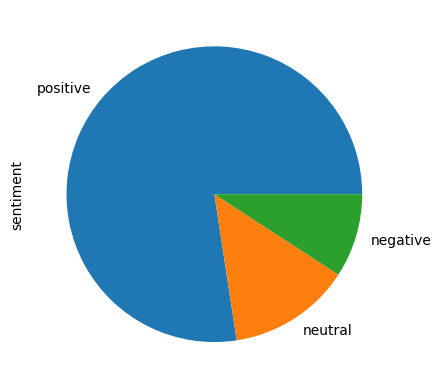

In [32]:
review['sentiment'].value_counts().plot(kind='pie')

In [33]:
def create_wordcloud(text):
    mask = np.array(Image.open("b.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=1500,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

#### Word Cloud for all the texts

Word Cloud Saved Successfully


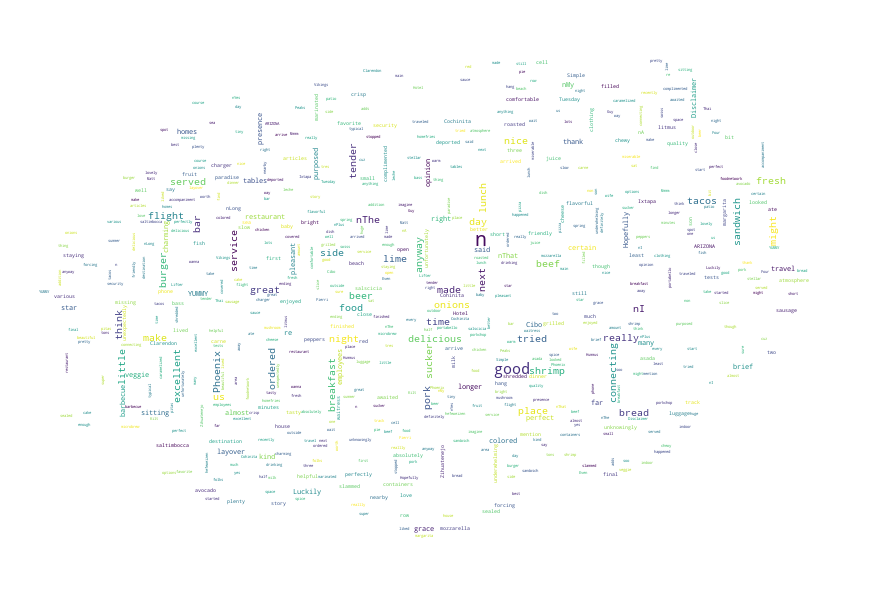

In [34]:
create_wordcloud(review["text"].values)


#### Word Cloud for negative texts

Word Cloud Saved Successfully


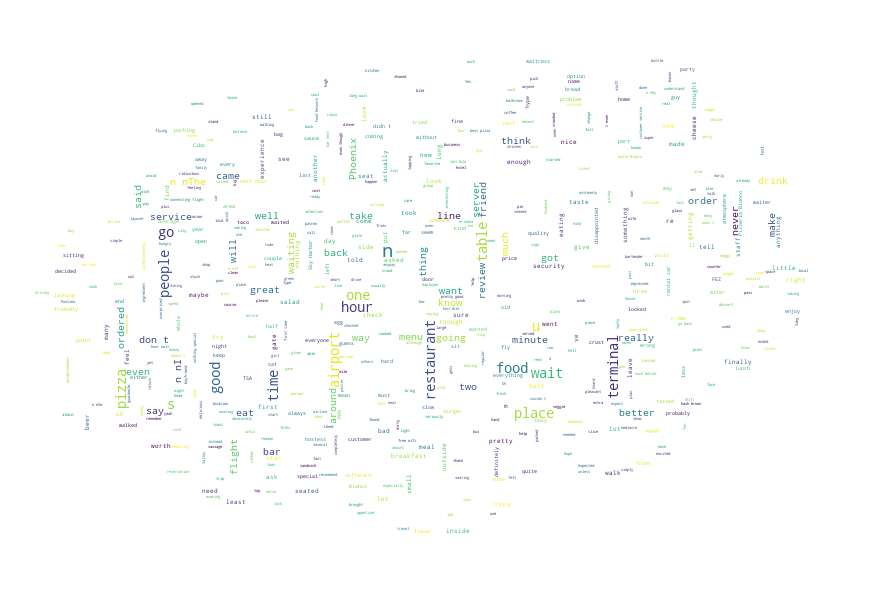

In [35]:
negative_values = review[review["sentiment"]=="negative"]

negative_values = negative_values["text"].values

create_wordcloud(negative_values)


#### Word Cloud for positive texts

Word Cloud Saved Successfully


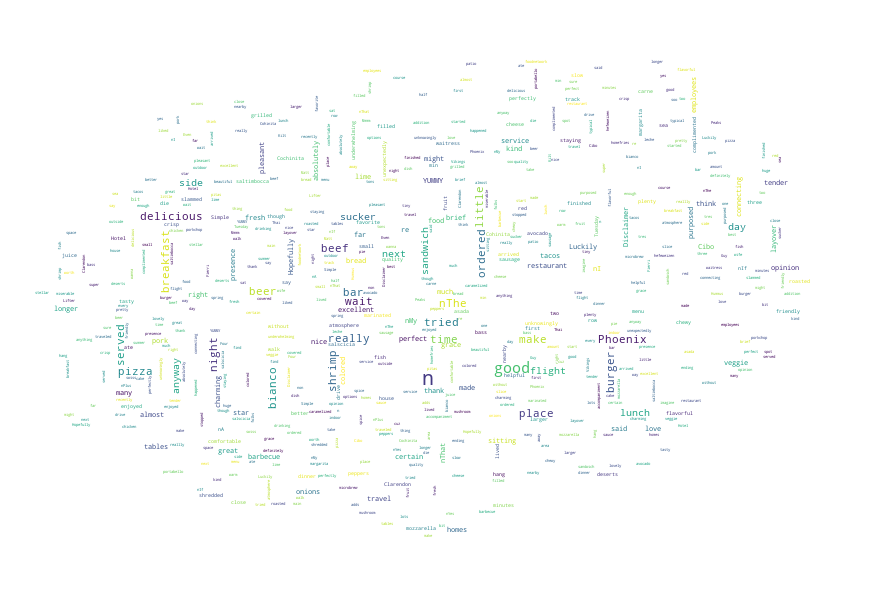

In [36]:
positive_values = review[review["sentiment"]=="positive"]

positive_values = positive_values["text"].values

create_wordcloud(positive_values)

#### Remove Punctuation

In [37]:
# Text preprocessing steps - remove numbers, captial letters, punctuation, new line


alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
new_line = lambda x: re.sub('\n',' ',x)

review['text'] = review.text.map(alphanumeric).map(punc_lower).map(new_line)
review.head()

,stars,sentiment,text
7,4,positive,luckily i didn t have to travel far to make m...
30,5,positive,disclaimer like many of you i am a sucker fo...
90,1,negative,the beach paradise of ixtapa zihuatenejo await...
108,5,positive,it s just like pizza bianco without the wait ...
146,3,neutral,i have been through plenty of airports around ...


In [38]:
for index, row in review['text'].iteritems():
    lang = detect(row) #detecting each row
    review.loc[index, 'Language'] = lang
    
review.head()

,stars,sentiment,text,Language
7,4,positive,luckily i didn t have to travel far to make m...,en
30,5,positive,disclaimer like many of you i am a sucker fo...,en
90,1,negative,the beach paradise of ixtapa zihuatenejo await...,en
108,5,positive,it s just like pizza bianco without the wait ...,en
146,3,neutral,i have been through plenty of airports around ...,en


In [39]:
count_values_in_column(review,"Language")

,Total,Percentage
en,6449,99.48
fr,5,0.08
nl,3,0.05
it,3,0.05
tr,3,0.05
af,3,0.05
cy,3,0.05
no,2,0.03
hu,2,0.03
ca,2,0.03


In [40]:
review.head()

,stars,sentiment,text,Language
7,4,positive,luckily i didn t have to travel far to make m...,en
30,5,positive,disclaimer like many of you i am a sucker fo...,en
90,1,negative,the beach paradise of ixtapa zihuatenejo await...,en
108,5,positive,it s just like pizza bianco without the wait ...,en
146,3,neutral,i have been through plenty of airports around ...,en


In [41]:
len(review)

6483

In [42]:
review.sentiment.value_counts(normalize=False)

positive    5019
neutral      870
negative     594
Name: sentiment, dtype: int64

In [43]:
review_es = review[review["Language"] == "en"]

len(review_es)

6449

In [44]:
review_es.head()

,stars,sentiment,text,Language
7,4,positive,luckily i didn t have to travel far to make m...,en
30,5,positive,disclaimer like many of you i am a sucker fo...,en
90,1,negative,the beach paradise of ixtapa zihuatenejo await...,en
108,5,positive,it s just like pizza bianco without the wait ...,en
146,3,neutral,i have been through plenty of airports around ...,en


### Data Transformation

#### Preprocess the Text

In [45]:
new_dataset = review_es[['sentiment','text']]

new_dataset.head()

,sentiment,text
7,positive,luckily i didn t have to travel far to make m...
30,positive,disclaimer like many of you i am a sucker fo...
90,negative,the beach paradise of ixtapa zihuatenejo await...
108,positive,it s just like pizza bianco without the wait ...
146,neutral,i have been through plenty of airports around ...


In [46]:
TAG_RE = re.compile(r'<[^>]+>')
                    
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


def remove_tags(text):
    return TAG_RE.sub('', text)


In [47]:
dataset = []

sentences = list(new_dataset['text'])

for sen in sentences:
    dataset.append(preprocess_text(sen))

In [48]:
dataset[3]

'it just like pizza bianco without the wait this pizza is and bianco is this place has much larger menu and their deserts are to die for if bianco has more then min wait just drive and or walk here '

In [49]:
list(dataset[:3])

['luckily didn have to travel far to make my connecting flight and for this thank you phoenix my brief layover was pleasant as the employees were kind and the flight was on time hopefully next time can grace phoenix with my presence for little while longer ',
 'disclaimer like many of you am sucker for charming little homes that have been re purposed into restaurants am certain that this colored my opinion of cibo that being said absolutely love having lunch here the other day unknowingly arrived at minutes after they close between lunch and dinner but was served anyway had the salscicia sandwich and side of fruit the sandwich was excellent served on perfectly crisp chewy saltimbocca bread the sausage was flavorful and was complimented by roasted red peppers and onions all this was finished off with great quality mozzarella cheese really really delicious should also say that the atmosphere here was friendly and comfortable though bit small this would be great place to hang out if you l

In [50]:
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 200 # 500
N_GLOVE_TOKENS = 400000
EMBEDDING_DIM = 100
epoch = 5

#### Tokenizer Data


In [51]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(dataset)
sequences = tokenizer.texts_to_sequences(dataset)
word_index = tokenizer.word_index

#### Data Padding

In [52]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

#### Labeling Sentiments

In [53]:
sentiments = np.array(new_dataset['sentiment'])

labels_index = { "neutral": 0, "negative": 1, "positive": 2}

labels = []

for i in range(len(sentiments)):
    if sentiments[i] == 'neutral':
        labels.append(0)
    if sentiments[i] == 'negative':
        labels.append(1)
    if sentiments[i] == 'positive':
        labels.append(2)
        
labels = np.array(labels)

In [54]:
labels

array([2, 2, 1, ..., 2, 2, 2])

In [55]:
labels = tf.keras.utils.to_categorical(labels, 3, dtype="float32")

labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [56]:
print ("data.shape = {0}, labels.shape = {1}".format(data.shape, labels.shape))

data.shape = (6449, 200), labels.shape = (6449, 3)


#### Split Data to Train and Test Set

In [57]:
x_train, x_test, y_train, y_test = train_test_split(data, labels)

### Model Design

#### Create Embeding Layer

In [58]:
# Load word embeddings

print("Loading word embeddings.")
embeddings_index = dict()


with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in tqdm.tqdm(f, total=N_GLOVE_TOKENS):
        values = line.split()
        word, coefficients = values[0], np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefficients
       

  1%|▋                                                                        | 3799/400000 [00:00<00:10, 37704.00it/s]

Loading word embeddings.


100%|███████████████████████████████████████████████████████████████████████| 400000/400000 [00:10<00:00, 37173.87it/s]


In [59]:
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
print ("embedding_matrix.shape = {0}".format(embedding_matrix.shape))

embedding_matrix.shape = (19306, 100)


#### Model Network

In [61]:
# sequence model
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
emb_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inputs)
lstm_layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(emb_layer)
output_layer = Dense(len(labels_index), activation="softmax")(lstm_layer)
model = Model(inputs, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          1930600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,015,467
Trainable params: 84,867
Non-trainable params: 1,930,600
_________________________________________________________________


#### Train Model

In [62]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [63]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                    epochs=10, batch_size=64, verbose=1)

Epoch 1/10
76/76 [==============================] - 213s 3s/step - loss: 0.7622 - acc: 0.7424 - val_loss: 0.6652 - val_acc: 0.7768
Epoch 2/10
76/76 [==============================] - 204s 3s/step - loss: 0.6717 - acc: 0.7679 - val_loss: 0.6695 - val_acc: 0.7768
Epoch 3/10
76/76 [==============================] - 208s 3s/step - loss: 0.6670 - acc: 0.7725 - val_loss: 0.6560 - val_acc: 0.7768
Epoch 4/10
76/76 [==============================] - 208s 3s/step - loss: 0.6267 - acc: 0.7781 - val_loss: 0.6168 - val_acc: 0.7768
Epoch 5/10
76/76 [==============================] - 209s 3s/step - loss: 0.6163 - acc: 0.7719 - val_loss: 0.6016 - val_acc: 0.7793
Epoch 6/10
76/76 [==============================] - 205s 3s/step - loss: 0.5755 - acc: 0.7757 - val_loss: 0.5628 - val_acc: 0.7793
Epoch 7/10
76/76 [==============================] - 205s 3s/step - loss: 0.5320 - acc: 0.7908 - val_loss: 0.5466 - val_acc: 0.7849
Epoch 8/10
76/76 [==============================] - 207s 3s/step - loss: 0.5152 - a

#### Graphical Representation

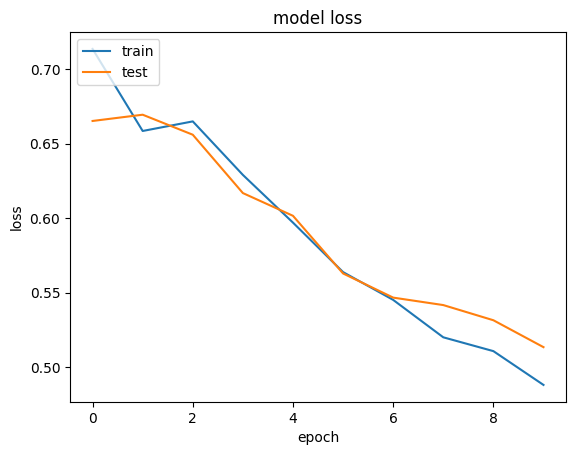

In [66]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Sample Review Analysis

In [70]:
sentiment = ['Neutral','Negative','Positive']

In [71]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]


'Positive'

In [72]:
sequence = tokenizer.texts_to_sequences(['Python is neither bad nor good, it is just there'])
test = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]


'Positive'